In [36]:
import cvxopt
import numpy as np
import random
import graphlab as gl
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def output_func(x1, x2, slope, point):
    output = slope*x1 - slope*point[0] + point[1] - x2
    return output

In [38]:
N = 100

features_1 = np.array(([[1]]*N))
features_2 = np.array((np.random.uniform(-1, 1., size=(N, 2)))) # generating two random, uniformly distributed points in [-1, 1]
features = np.hstack((features_1, features_2))

# random points of the random line that determine the output (+1, -1)
function_f_points = np.array((np.random.uniform(-1, 1., size=(2, 2))))   

# Calculate the slope
slope = (function_f_points[1,1] - function_f_points[0,1])/(function_f_points[1,0] - function_f_points[0,0])

# Calculate the output
output = output_func(features_2[:,0], features_2[:,1], slope, function_f_points[0,:])
output = list(gl.SArray(np.sign(output)))

In [39]:
# Combine all features and output
features_output = np.hstack((features, np.array((output)).reshape(N,1)))

# Determine the positive points and negative points
pos_list = list()
neg_list = list()

for i in features_output:
    if i[3] == 1:
        pos_list.append([i[1],i[2]])
    elif i[3] == -1:
        neg_list.append([i[1],i[2]])

#print pos_list
#print neg_list

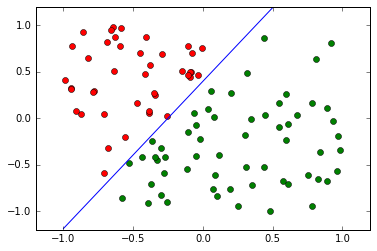

In [40]:
# Draw the positive and negative points
for i in pos_list:
    plt.plot(i[0], i[1], "ro", c='green')

for i in neg_list:   
    plt.plot(i[0], i[1], "ro", c='red')


# Draw the random line
x_list = list()
y_list = list()

for x in range(-1, 2):
        x_list.append(x)
        
        y = slope*x - slope*function_f_points[0,:][0] + function_f_points[0,:][1] 
        y_list.append(y)

#print slope

axes = plt.gca()
axes.set_xlim([-1.2,1.2])
axes.set_ylim([-1.2,1.2])
plt.plot(x_list, y_list)

In [41]:
# Quadratic coefficients
for i in xrange(N):
    
    f_new = np.array(([np.dot(output[i]*output[j]*features_2[i,:].transpose(), features_2[j,:]) for j in xrange(N)]))
    
    # combine the matrix lines
    if i == 0:
        f = np.array(f_new)      
    else: 
        f = np.vstack((f, f_new))

#print f

In [42]:
P = cvxopt.matrix(f, tc='d')
q = cvxopt.matrix(np.ones(N) * -1, tc='d')
G = cvxopt.matrix(np.diag(np.ones(N) * -1))
h = cvxopt.matrix(np.zeros(N))
A = cvxopt.matrix(output, (1,N))
b = cvxopt.matrix(0.0)

In [43]:
# Solve the quadratic program

#cvxopt.solvers.options['show_progress'] = False # Turn off the 'show_progress'

sol = cvxopt.solvers.qp(P,q,G,h,A,b)
#print sol['x']

     pcost       dcost       gap    pres   dres
 0: -3.0325e+01 -6.6176e+01  4e+02  2e+01  2e+00
 1: -7.7938e+01 -8.6178e+01  2e+02  8e+00  9e-01
 2: -1.2439e+02 -1.3022e+02  2e+02  8e+00  9e-01
 3: -5.4734e+02 -5.0830e+02  2e+02  7e+00  9e-01
 4: -5.3276e+02 -5.1700e+02  4e+02  6e+00  8e-01
 5: -5.6564e+02 -5.4859e+02  4e+02  5e+00  6e-01
 6: -4.6027e+02 -4.8484e+02  3e+02  2e+00  2e-01
 7: -3.9161e+02 -3.9411e+02  1e+01  7e-02  8e-03
 8: -3.9147e+02 -3.9151e+02  2e-01  8e-04  1e-04
 9: -3.9147e+02 -3.9147e+02  2e-03  8e-06  1e-06
10: -3.9147e+02 -3.9147e+02  2e-05  8e-08  1e-08
Optimal solution found.


In [44]:
# Lagrange multipliers
all_a = np.ravel(sol['x'])

# Support vectors have non zero lagrange multipliers
sv = all_a > 1e-5
#print sv
ind = np.arange(len(all_a))[sv]
#print ind

a = all_a[sv]
#print a
sv_features = features_2[sv]
#print sv
sv_y = np.array(output)[sv]
print "%d support vectors out of %d points" % (len(a), N)

K = np.zeros((N, N))
for i in xrange(N):
    for j in xrange(N):
        K[i,j] = np.dot(features_2[i], features_2[j])


4 support vectors out of 100 points


In [45]:
# Intercept -- Average all support vectors' intercept value
b = 0
for n in xrange(len(a)):
    b += sv_y[n]
    b -= np.sum(a * sv_y * K[ind[n],sv])
    
b /= len(a)
print b

# Weights
weights = np.zeros(2)
for n in xrange(len(a)):
    weights += a[n] * sv_y[n] * sv_features[n] 
print weights

5.17564578012
[ 22.67067198 -16.40069812]


In [46]:
# Using the formula to check the intercept value 

b_list = list()
for i in ind:  
    x_list = list()
    y_list = list()

    b_temp = 1/float(output[i]) - np.dot(weights,features_2[i]) 
    
    print b_temp
    
    b_list.append(b_temp)

print sum(b_list) / float(len(b_list))

5.09773580636
5.20161569801
5.20161572948
5.20161588663
5.17564578012


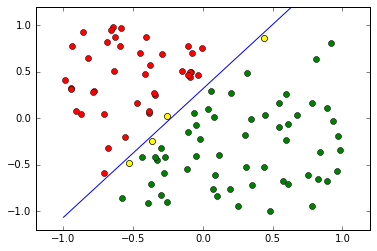

In [47]:
# Draw the positive and negative points
for i in pos_list:
    plt.plot(i[0], i[1], "ro", c='green')

for i in neg_list:   
    plt.plot(i[0], i[1], "ro", c='red')

# Draw the support vector points
for i in ind:
    plt.plot(features_2[i][0], features_2[i][1], "ro", c='yellow')

# Draw the linear SVM line    
x_list = list()
y_list = list() 

for x in range(-1, 2):
    x_list.append(x)

    y = - (weights[0]*x + b_temp)/weights[1]
    y_list.append(y)
    

axes = plt.gca()
axes.set_xlim([-1.2,1.2])
axes.set_ylim([-1.2,1.2])
plt.plot(x_list, y_list) 
